In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
class Balls:
    
    def __init__(self, N, dim, boundary, T, Temp, k=1, m=1):
        
        self.N        = N
        self.k        = k
        self.T        = T
        self.dim      = dim
        self.Temp     = Temp
        self.boundary = boundary
        
        np.random.seed(0)
        self.pos = 2*np.random.rand(N,dim)-1
        
        np.random.seed(1)
        sigma    = np.sqrt(k*Temp/m)
        self.vel = sigma*np.random.randn(N,dim)
        
        self.rad  = 0.2*np.ones(N)
        self.mass = m*np.ones(N)
        
        self.t      = [0]
        self.tc     = []
        self.tc_all = np.full((N,2*dim+N), float(T))
        
        self.results_pos = []
        self.results_vel = []
        
        return
    
    def evolve(self):
        
        t       = self.t[0]
        T       = self.T
        record  = self.record
        iterate = self.iterate
        
        record()
        
        while t < T:
    
            iterate()
            
            t = self.t[-1]
        
        self.tc.pop() 
        
        return
    
    def iterate(self):
        
        move             = self.move
        tc_BC            = self.tc_boundary
        record           = self.record
        tc_min           = self.tc_min
        collide_BC       = self.collide_boundary
        tc_balls_2D      = self.tc_balls_2D
        collide_balls_2D = self.collide_balls_2D
        
        tc_BC()
        
        tc_balls_2D()
        
        tc_min()
        
        dt = min(self.tc[-1],T-self.t[-1])
        
        move(dt)
        
        index_BC   = self.collision_index[:,0:2*dim]
        index_Ball = self.collision_index[:,2*dim:]
        
        if np.any(index_BC):
            collide_BC()
        elif np.any(index_Ball):
            collide_balls_2D()
        else:
            pass
                
        self.t.append(self.t[-1]+dt)
            
        record()
        
        return
    
    def record(self):
        
        pos = self.pos
        vel = self.vel
        
        self.results_pos.append(pos)
        self.results_vel.append(vel)
        
        return
    
    def move(self, dt):
        
        pos = self.pos
        vel = self.vel
        
        pos = pos + vel*dt
        
        self.pos = pos
        
        return
    
    def tc_boundary(self):
        
        T       = self.T
        BC      = self.boundary
        dim     = self.dim
        pos     = self.pos
        vel     = self.vel
        
        tc_BC_u = np.full(pos.shape, float(T)) # tc for upper boundary
        tc_BC_d = np.full(pos.shape, float(T)) # tc for lower boundary
        
        U = vel>0
        D = vel<0
    
        tc_BC_u[U] = ( BC - pos[U] )/vel[U]
        tc_BC_d[D] = (-BC - pos[D] )/vel[D]
        
        self.tc_all[:,0:dim]     = tc_BC_u
        self.tc_all[:,dim:2*dim] = tc_BC_d
        
        return
    
    def tc_balls_2D(self):
        
        R   = self.rad
        T   = self.T
        dim = self.dim
        pos = self.pos
        vel = self.vel
        
        x  = pos[:,0]
        y  = pos[:,1]
        vx = vel[:,0]
        vy = vel[:,1]

        xi, xj   = np.meshgrid(x,x,indexing='ij')
        yi, yj   = np.meshgrid(y,y,indexing='ij')
        vxi, vxj = np.meshgrid(vx,vx,indexing='ij')
        vyi, vyj = np.meshgrid(vy,vy,indexing='ij')

        Ri, Rj = np.meshgrid(R,R,indexing='ij')

        xij  = xj - xi
        yij  = yj - yi
        vxij = vxj - vxi
        vyij = vyj - vyi

        Rij = Rj + Ri
        
        J = np.full(Rij.shape,True)
        J = np.triu(J, k=1)          # upper triangle to speedup

        r_d_v = np.zeros(Rij.shape)
        r_s   = r_d_v.copy()
        v_s   = r_d_v.copy()
        R_s   = r_d_v.copy()
        D     = r_d_v.copy()
        
        r_d_v[J]  = xij[J]*vxij[J] + yij[J]*vyij[J]    # r dot v
        r_s[J]    = xij[J]**2 + yij[J]**2              # r square
        v_s[J]    = vxij[J]**2 + vyij[J]**2            # v square
        R_s[J]    = Rij[J]**2                          # R square
        D[J]      = r_d_v[J]**2-v_s[J]*(r_s[J]-R_s[J]) # Discriminant
        J         = D>0

        tc_balls      = np.full(Rij.shape, float(T))
        tc_balls[J]   = (-r_d_v[J] - np.sqrt(D[J]))/v_s[J]
        tc_balls[J.T] = tc_balls.T[J.T]
        
        tc_balls[tc_balls<=0] = T
        
        self.tc_all[:,2*dim:] = tc_balls
        
        return
    
    def tc_min(self):
        
        tc_all = self.tc_all
        self.tc.append(np.min(tc_all))
        self.collision_index = tc_all==np.min(tc_all)
        
        return
    
    def collide_boundary(self):
        
        dim      = self.dim
        vel      = self.vel
        index_BC = self.collision_index[:,0:2*dim]
        
        vel[index_BC[:,0:dim]] = -vel[index_BC[:,0:dim]]
        vel[index_BC[:,dim:]]  = -vel[index_BC[:,dim:]]
        
        self.vel = vel
    
        return
    
    def collide_balls_2D(self):
        
        i   = self.collision_index[:,2*dim:]
        m   = self.mass
        pos = self.pos
        vel = self.vel
        
        x  = pos[:,0]
        y  = pos[:,1]
        vx = vel[:,0]
        vy = vel[:,1]
        
        xi, xj   = np.meshgrid(x,x,indexing='ij')
        yi, yj   = np.meshgrid(y,y,indexing='ij')
        mi, mj   = np.meshgrid(m,m,indexing='ij')
        vxi, vxj = np.meshgrid(vx,vx,indexing='ij')
        vyi, vyj = np.meshgrid(vy,vy,indexing='ij')

        xij  = xi - xj
        yij  = yi - yj
        vxij = vxi - vxj
        vyij = vyi - vyj
        
        C    = np.zeros(mi.shape)
        C[i] = 2*mj[i]/(mi[i]+mj[i])*(vxij[i]*xij[i]+vyij[i]*yij[i])/(xij[i]**2+yij[i]**2)
        
        vx_f    = np.zeros(mi.shape)
        vx_f[i] = vxi[i] - C[i]*xij[i]
        vy_f    = np.zeros(mi.shape)
        vy_f[i] = vyi[i] - C[i]*yij[i]
        
        vx_f = np.sum(vx_f,axis=1)
        vy_f = np.sum(vy_f,axis=1)
        
        i_1D = np.any(i, axis=1)
        
        vx[i_1D] = vx_f[i_1D]
        vy[i_1D] = vy_f[i_1D]
        
        vel[:,0] = vx.copy()
        vel[:,1] = vy.copy()
        
        self.vel = vel
        
        return


In [20]:
numbers  = 10                  # particle numbers
dim      = 2                   # dimension
boundary = 4                   # boundary
T        = 10                  # total time
Temp     = 50                   # Temperature

balls = Balls(numbers, dim, boundary, T, Temp) # balls

balls.evolve()

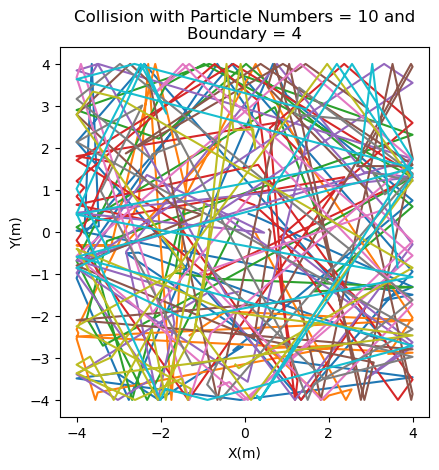

In [21]:
 
N    = balls.N
BC   = balls.boundary
pos  = np.array(balls.results_pos)

for i in range(N):
            
    plt.plot(pos[:,i,0], pos[:,i,1])
        
plt.axis('square')
plt.title(f'Collision with Particle Numbers = {N} and\nBoundary = {BC}')
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.savefig(f'N_{N}_particles_with_boundary.png')
        

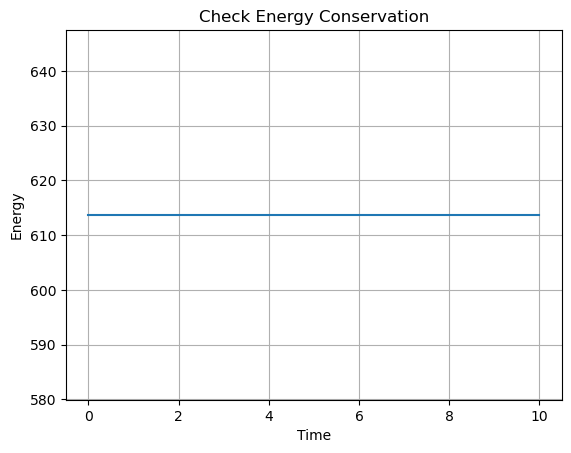

In [22]:

t   = balls.t
m   = balls.mass
vel = np.array(balls.results_vel)
E   = []

for i in range(len(t)):
    E.append(0.5*np.sum(m*(vel[i,:,0]**2+vel[i,:,1]**2)))

plt.plot(t,E)
plt.grid()
plt.title('Check Energy Conservation')
plt.xlabel('Time')
plt.ylabel('Energy');

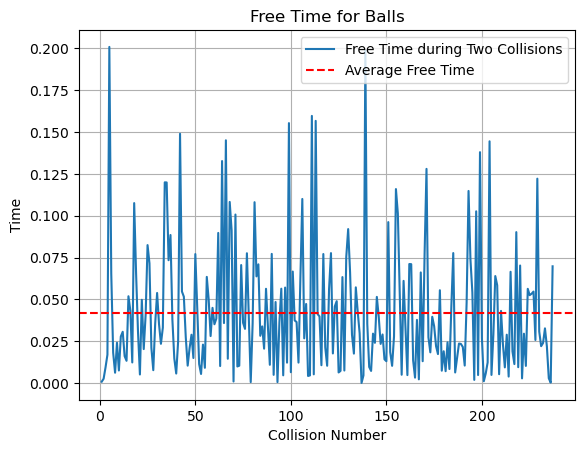

In [23]:

tc = balls.tc
x = [i+1 for i in range(len(tc))]
plt.plot(x,tc,label='Free Time during Two Collisions')
plt.axhline(y=np.sum(tc)/len(tc), color='r', linestyle='--',label='Average Free Time')
plt.grid()
plt.legend()
plt.title('Free Time for Balls')
plt.xlabel('Collision Number')
plt.ylabel('Time');


In [7]:
r = np.array([[0,0],[1,0]])
v = np.array([[1,0],[0,0]])
R = np.array([0.2,0.2])

x = r[:,0]
y = r[:,1]

vx = v[:,0]
vy = v[:,1]

xi, xj = np.meshgrid(x,x,indexing='ij')
yi, yj = np.meshgrid(y,y,indexing='ij')

vxi, vxj = np.meshgrid(vx,vx,indexing='ij')
vyi, vyj = np.meshgrid(vy,vy,indexing='ij')

Ri, Rj = np.meshgrid(R,R,indexing='ij')

xij = xj - xi
yij = yj - yi

vxij = vxj - vxi
vyij = vyj - vyi

Rij = Rj + Ri

r_d_v  = xij*vxij + yij*vyij # r dot v
r_s    = xij**2 + yij**2     # r square
v_s    = vxij**2 + vyij**2   # v square
R_s    = Rij**2              # R square


T = np.full(r_s.shape,True)
T = np.triu(T, k=1) # upper triangle to speedup
D = r_d_v**2-v_s*(r_s-R_s)
J = T&(D>=0)

tc = np.zeros(Rij.shape)
tc[J] = (-r_d_v[J] - np.sqrt(D[J]))/v_s[J]
print(tc)

[[0.  0.6]
 [0.  0. ]]


In [8]:
v = np.array([1,0])
m = np.array([1,3])

vi, vj = np.meshgrid(v,v,indexing='ij')
mi, mj = np.meshgrid(m,m,indexing='ij')

vij = (vi*(mi-mj)+2*mj*vj)/(mi+mj)

print(vij)

[[ 1.  -0.5]
 [ 0.5  0. ]]


In [9]:
a = np.arange(8.).reshape(2,2,2)
b = np.arange(8.).reshape(2,2,2)
c = np.dot(a,b)

print('a=',a)
print('b=',b)
print('c=',c)

a= [[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]
b= [[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]
c= [[[[ 2.  3.]
   [ 6.  7.]]

  [[ 6. 11.]
   [26. 31.]]]


 [[[10. 19.]
   [46. 55.]]

  [[14. 27.]
   [66. 79.]]]]


In [10]:
balls.t

[0,
 0.0008765444931941381,
 0.003513684717188057,
 0.012900898462761596,
 0.029900154810321267,
 0.23066531603285684,
 0.29622671611832135,
 0.31442671313298753,
 0.3206686125982937,
 0.34481606085402355,
 0.35239352771359217,
 0.3802176095017205,
 0.4109037362543909,
 0.42706435186855124,
 0.44041575164899016,
 0.4923131471724392,
 0.5355641215277278,
 0.5479368026954595,
 0.6554573990161615,
 0.7209998676514888,
 0.7515614258722066,
 0.7567408875241668,
 0.8065269092394514,
 0.8268738968168158,
 0.8676803432222387,
 0.9501255781122978,
 1.0216903126080392,
 1.0428237570202572,
 1.0505804386822453,
 1.08627783515256,
 1.1401400175521537,
 1.1754434940300955,
 1.198952460257106,
 1.2321252342599371,
 1.352034460085476,
 1.4718833489002352,
 1.5452978819234475,
 1.63376449844431,
 1.6716547994438502,
 1.686409599034882,
 1.6921647051953363,
 1.7170321651686247,
 1.865942779550922,
 1.9206716123205818,
 1.97228300441454,
 1.999732568584446,
 2.0101987344247383,
 2.031137011629651,
 2.06

In [11]:
np.any([False,False])

False

In [12]:
np.any([True,False])

True

In [13]:
np.any([[True, False, False], [False, False, False]], axis=0)

array([ True, False, False])

In [14]:
len(tc)

2

In [15]:
len(t)

486